In [2]:
pip install openai-clip

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from PIL import Image
import torch
import clip   
import tarfile
import pickle
import os
import matplotlib.pyplot as plt


In [4]:
# 下载模型
# https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
# 下载数据
# http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [9]:
# 加载模型
def load_model(model_path, text_label):
    model, process = clip.load(model_path, device=device)
    text = clip.tokenize(text_label).to(device)
    return model, process, text


# 预测
def predict(model, process, image, text):
    with torch.no_grad():
        image = process(image).unsqueeze(0).to(device)
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=1).cpu().numpy()
    label = ""
    prob = 0.0
    for i in range(len(text_label)):
      
    
    
    
        print(f"Label='{text_label[i]}', prob={probs[0][i]}")
        if probs[0][i] > prob:
            prob = probs[0][i]
            label = text_label[i]
    return label


def load_data(data_path):
    # http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    def extract_tar_gz(file_path, extract_dir):
        with tarfile.open(file_path, 'r:gz') as tar:
            tar.extractall(extract_dir)

    if not os.path.exists("./data/files"):
        os.makedirs("./data_files")
    extract_tar_gz(data_path, "./data/files")
    data_path = "./data/files/cifar-10-batches-py"

    with open(data_path + "/data_batch_1", 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def score(y, pre):
    # 计算整体准确率
    n = len(y)
    if n == 0:
        return 0
    cnt = 0
    for i in range(n):
        if y[i] == pre[i]:
            cnt += 1
        else:
            pass
    return cnt/n


def score_by_cls(y, pre):
    # 分别计算每个类别的准确率
    dic = dict()
    n = len(y)
    if n == 0:
        return None

    for i in range(n):
        label = y[i]
        pre_label = pre[i]
        if label not in dic:
            dic[label] = (0, 0)
        if label == pre_label:
            dic[label] = (dic[label][0] + 1, dic[label][1] + 1)
        else:
            dic[label] = (dic[label][0] + 1, dic[label][1])

    for key in dic:
        dic[key] = dic[key][1]/dic[key][0]

    return dic

Label='this is an airplane', prob=0.0504150390625
Label='this is an automobile', prob=0.036895751953125
Label='this is a bird', prob=0.268310546875
Label='this is a cat', prob=0.09271240234375
Label='this is a deer', prob=0.03155517578125
Label='this is a dog', prob=0.046630859375
Label='this is a frog', prob=0.256103515625
Label='this is a horse', prob=0.1136474609375
Label='this is a ship', prob=0.08709716796875
Label='this is a truck', prob=0.016632080078125
this is a frog, this is a bird
Label='this is an airplane', prob=0.006084442138671875
Label='this is an automobile', prob=0.08270263671875
Label='this is a bird', prob=0.00489044189453125
Label='this is a cat', prob=0.0015869140625
Label='this is a deer', prob=0.0016126632690429688
Label='this is a dog', prob=0.0013790130615234375
Label='this is a frog', prob=0.0009627342224121094
Label='this is a horse', prob=0.0045928955078125
Label='this is a ship', prob=0.007114410400390625
Label='this is a truck', prob=0.88916015625
this is

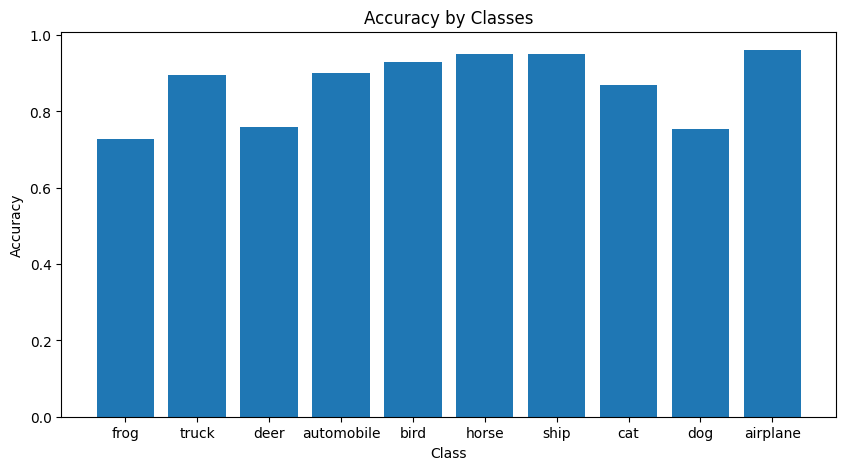

In [10]:
if __name__ == '__main__':
   
    
    # https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt
    model_path = "/data/lab/ass2/ViT-B-32.pt"
    data_path = "/data/lab/ass2/cifar-10-python.tar.gz"
    MAX_IMAGES = 1000 # 调整该参数可设定要测试多少张图片
    text_label = [
                    "this is an airplane",
                    "this is an automobile",
                    "this is a bird",
                    "this is a cat",
                    "this is a deer",
                    "this is a dog",
                    "this is a frog",
                    "this is a horse",
                    "this is a ship",
                    "this is a truck"
                ]
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, process, text = load_model(model_path, text_label)
    data = load_data(data_path)
    labels = data[b"labels"]
    imgs = data[b"data"]
    imgs = imgs.reshape(len(imgs), 3, 32, 32)
    imgs = imgs.transpose(0, 2, 3, 1)
    true_label_lst = []
    predict_label_lst = []
    
    for i in range(len(imgs)):
        img = imgs[i]
        img = Image.fromarray(img)
        label = text_label[labels[i]]
        pre_label = predict(model, process, img, text)
        true_label_lst.append(label)
        predict_label_lst.append(pre_label)
        print(f"{label}, {pre_label}")
        if i > 1000:
            break
    s = score(true_label_lst, predict_label_lst)
    s_cls = score_by_cls(true_label_lst, predict_label_lst)
    print(f"accuracy: {s}")
    print(f"accuracy by classes: {s_cls}")
    plt.figure(figsize=(10, 5))
    plt.bar([item.split(" ")[-1] for item in s_cls.keys()], s_cls.values())
    plt.title("Accuracy by Classes")
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.show()